In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Ensure 'achromatcfw' module is on the path
sys.path.append(str(Path('..').resolve() / 'src'))
from chromf.cfw import fringe_width
from achromatcfw.data.glass_map.schott_glass import glass_db

In [2]:
# ----- Defocus sampling parameters -----
defocus_range = 1000  # ± range in µm
defocus_step  = 10    # step in µm
z_vals = np.arange(-defocus_range, defocus_range + defocus_step, defocus_step)

In [3]:
# ----- Core computation: direct model only -----
def compute_direct_cfw_max(g1: str, g2: str, f0: float,
                            lam1: float, lam2: float, lam0: float) -> float:
    """
    Compute the maximum circle-with-focus (CFW) width through defocus for a given
    achromat design (g1 + g2), focal length f0, and wavelengths lam1, lam2, lam0.

    Removes Conrady analytic model; only uses the direct Δz model.
    Constraints (λ2 > λ1, λ2 - λ1 > 100) must be enforced by the caller.
    """
    # design power
    Phi0_req = 1.0 / f0

    # Conrady coefficients for each glass
    a1, b1, c1 = (glass_db[g1][k] for k in ("a", "b", "c"))
    a2, b2, c2 = (glass_db[g2][k] for k in ("a", "b", "c"))

    # Achromat condition: ratio r
    delta_nu   = 1/lam1 - 1/lam2
    delta_nu35 = 1/lam1**3.5 - 1/lam2**3.5
    r = -(b1*delta_nu + c1*delta_nu35) / (b2*delta_nu + c2*delta_nu35)

    # Solve for K1, K2
    denom = (a1 + r*a2) + (b1 + r*b2)/lam0 + (c1 + r*c2)/lam0**3.5
    K1 = Phi0_req / denom
    K2 = r * K1

    # Total power coefficients
    a_tot = a1*K1 + a2*K2
    b_tot = b1*K1 + b2*K2
    c_tot = c1*K1 + c2*K2

    # Sample wavelengths for CHL data (Δz vs λ)
    lam_sample = np.arange(400, 701, 10)
    def Phi_tot(lam):
        return a_tot + b_tot/lam + c_tot/lam**3.5
    mm_to_um = 1e3
    dz_sample = mm_to_um * (1.0/Phi_tot(lam_sample) - 1.0/Phi_tot(lam0))

    # Compute through-focus widths
    widths = np.array([Farbsaumbreite(z, CHLdata=dz_sample) for z in z_vals])
    return widths.max()

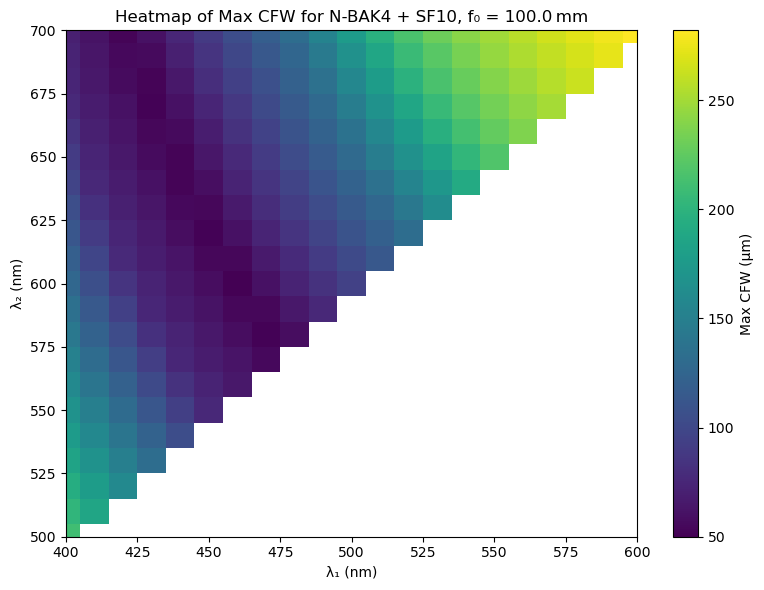

In [8]:
# Parameters
g1, g2 = 'N-BAK4', 'SF10'
f0 = 100.0  # mm
lam0 = 550.0  # nm, design wavelength

lam1_vals = np.arange(400, 601, 10)
lam2_vals = np.arange(500, 701, 10)

n1 = len(lam1_vals)
n2 = len(lam2_vals)

heatmap = np.full((n2, n1), np.nan)

for i, lam1 in enumerate(lam1_vals):
    for j, lam2 in enumerate(lam2_vals):
        if lam2 > lam1 and (lam2 - lam1) >= 100:
            heatmap[j, i] = compute_direct_cfw_max(g1, g2, f0, lam1, lam2, lam0)

masked = np.ma.masked_invalid(heatmap)

L1, L2 = np.meshgrid(lam1_vals, lam2_vals)


fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(L1, L2, masked, shading='auto')
fig.colorbar(c, label='Max CFW (µm)')
ax.set_xlim(lam1_vals.min(), lam1_vals.max())
ax.set_ylim(lam2_vals.min(), lam2_vals.max())
ax.set_xlabel('λ₁ (nm)')
ax.set_ylabel('λ₂ (nm)')
ax.set_title(f'Heatmap of Max CFW for {g1} + {g2}, f₀ = {f0} mm')

plt.tight_layout()
plt.show()